Mounted at /content/drive
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Loading all datasets...
Total images collected: 2988 (996 per lighting)
Image shape: (139, 250)
Dataloader ready with 47 batches
Models initialized and ready!
Generator params: 25.76M
Discriminator params: 2.83M
Starting training for 1000 epochs...
[0/1000][0/47] Loss_D: 1.8482 Loss_G: 5.5412 D(x): 0.6922 D(G(z)): 0.3829/0.0079
[0/1000][20/47] Loss_D: 7.5687 Loss_G: 13.5177 D(x): 0.9998 D(G(z)): 0.3246/0.0001
[0/1000][40/47] Loss_D: 7.0525 Loss_G: 14.6991 D(x): 0.9749 D(G(z)): 0.1636/0.0094
Checkpoint saved at epoch 0
[1/1000][0/47] Loss_D: 11.0325 Loss_G: 12.7750 D(x): 0.5683 D(G(z)): 0.0078/0.0011
[1/1000][20/47] Loss_D: 3.7583 Loss_G: 10.2780 D(x): 0.7551 D(G(z)): 0.5026/0.0276
[1/1000][40/47] Loss_D: 5.4650 Loss_G: 2.0707 D(x): 0.1071 D(G(z)): 0.0029/0.8339
[2/1000][0/47] Loss_D: 2.4611 Loss_G: 2.7925 D(x): 0.4884 D(G(z)): 0.0174/0.2974
[2/1000][20/47] Loss_D: 1.5161 Loss_G: 4.4243 D(x): 0.9617 D(G(z)): 0.3434/

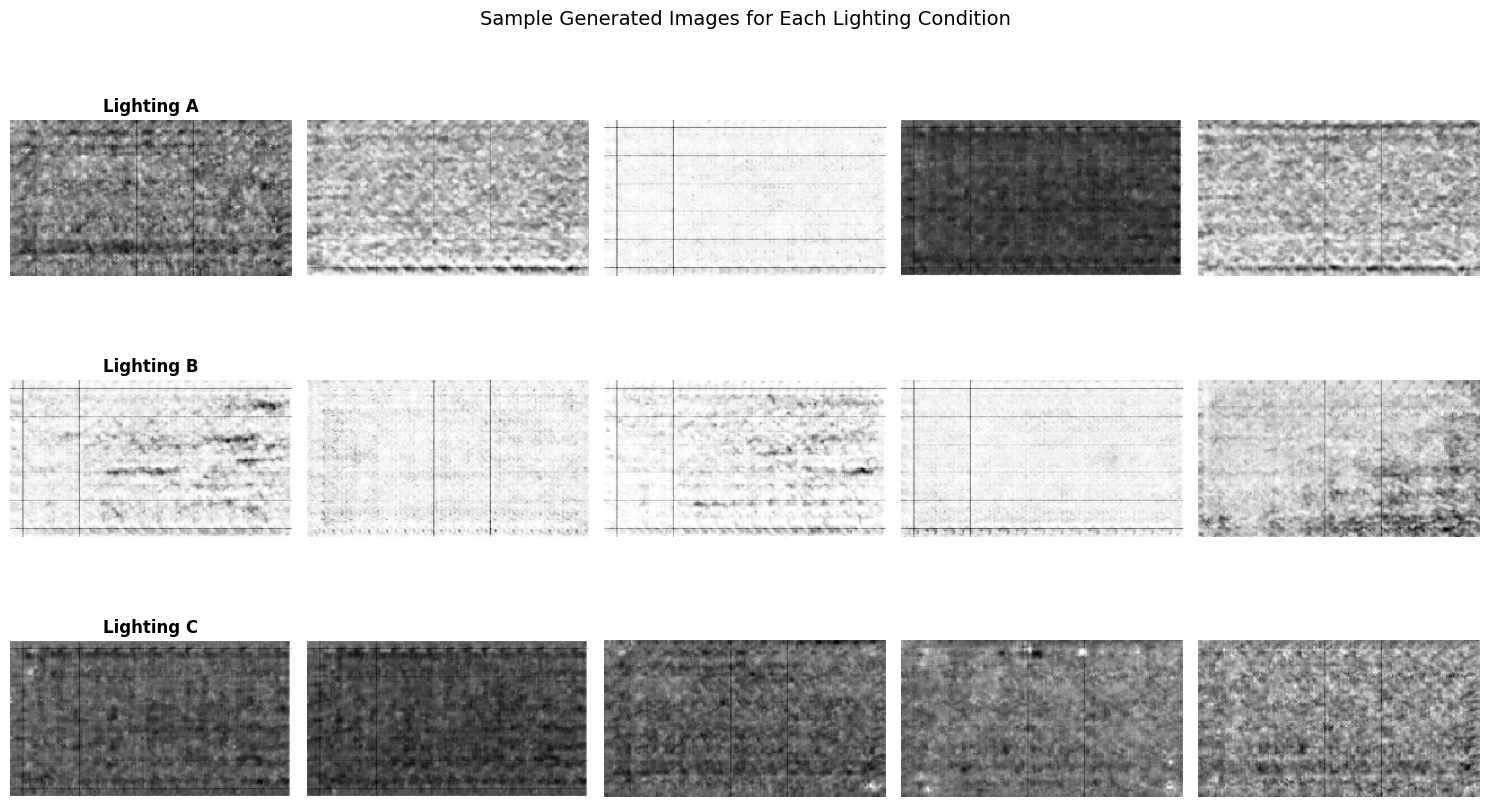

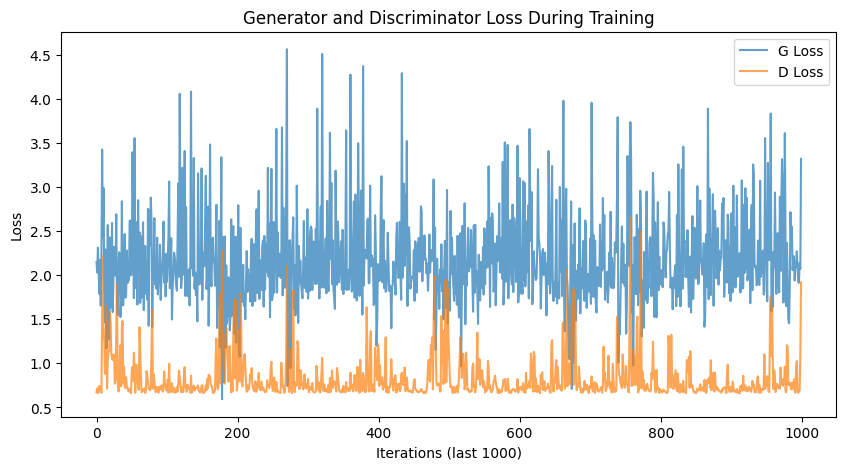


✅ Task 2 Complete!
Generated 300 synthetic powder spreading images (100 per lighting condition)
All images saved to: /content/drive/MyDrive/Hackathon_Challenge2/generated_images/


In [1]:
# %% [markdown]
# # DCGAN for NIST Task 2 - Synthetic Powder Spreading Image Generation

# %% [markdown]
# ## Setup and Imports

# %%
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# %% [markdown]
# ## Load ALL Available Data (Labeled + Unlabeled + Test)

# %%
base_path = "/content/drive/MyDrive/Hackathon_Challenge2/"

print("Loading all datasets...")
# Load labeled training set
labeled_d = pickle.load(open(base_path + "labeled_training_set.pkl", "rb"))

# Load unlabeled training set
unlabeled_d = pickle.load(open(base_path + "unlabeled_training_set.pkl", "rb"))

# Load test set
test_d = pickle.load(open(base_path + "test_set.pkl", "rb"))

# Collect all images from ALL lighting conditions
all_images_a = []
all_images_b = []
all_images_c = []

# From labeled set
for part in labeled_d.keys():
    for item in labeled_d[part]:
        lid = item['layer_id']
        # Collect all three lighting conditions
        img_a = np.mean(item['images'][f'A{lid}a'], axis=2).astype(np.float32)
        img_b = np.mean(item['images'][f'A{lid}b'], axis=2).astype(np.float32)
        img_c = np.mean(item['images'][f'A{lid}c'], axis=2).astype(np.float32)
        all_images_a.append(img_a)
        all_images_b.append(img_b)
        all_images_c.append(img_c)

# From unlabeled set
for part in unlabeled_d.keys():
    for item in unlabeled_d[part]:
        lid = item['layer_id']
        img_a = np.mean(item['images'][f'A{lid}a'], axis=2).astype(np.float32)
        img_b = np.mean(item['images'][f'A{lid}b'], axis=2).astype(np.float32)
        img_c = np.mean(item['images'][f'A{lid}c'], axis=2).astype(np.float32)
        all_images_a.append(img_a)
        all_images_b.append(img_b)
        all_images_c.append(img_c)

# From test set
for part in test_d.keys():
    for item in test_d[part]:
        lid = item['layer_id']
        img_a = np.mean(item['images'][f'A{lid}a'], axis=2).astype(np.float32)
        img_b = np.mean(item['images'][f'A{lid}b'], axis=2).astype(np.float32)
        img_c = np.mean(item['images'][f'A{lid}c'], axis=2).astype(np.float32)
        all_images_a.append(img_a)
        all_images_b.append(img_b)
        all_images_c.append(img_c)

# Combine all lighting conditions for training
all_images = all_images_a + all_images_b + all_images_c

print(f"Total images collected: {len(all_images)} ({len(all_images_a)} per lighting)")
print(f"Image shape: {all_images[0].shape}")

# %% [markdown]
# ## Dataset Class

# %%
class PowderDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        # Normalize to [-1, 1] for DCGAN
        img = (img / 255.0) * 2.0 - 1.0
        # Add channel dimension
        img = torch.FloatTensor(img).unsqueeze(0)  # (1, 139, 250)
        # Pad to 144x256 for easier convolutions (divisible by 16)
        img = torch.nn.functional.pad(img, (3, 3, 2, 3), value=-1.0)  # (1, 144, 256)
        return img

# Create dataset and dataloader
dataset = PowderDataset(all_images)
batch_size = 64  # A100 can handle this easily
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print(f"Dataloader ready with {len(dataloader)} batches")

# %% [markdown]
# ## DCGAN Architecture

# %%
# Generator
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=1):
        super(Generator, self).__init__()
        # nz: latent vector size
        # ngf: generator feature maps
        # nc: number of channels (1 for grayscale)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # state size: (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 16, (9, 16), 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size: (ngf*16) x 9 x 16

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf*8) x 18 x 32

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf*4) x 36 x 64

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf*2) x 72 x 128

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 144 x 256
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        # nc: number of channels
        # ndf: discriminator feature maps

        self.main = nn.Sequential(
            # input is (nc) x 144 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 72 x 128

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 36 x 64

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 18 x 32

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 9 x 16

            nn.Conv2d(ndf * 8, 1, (9, 16), 1, 0, bias=False),
            nn.Sigmoid()
            # state size: 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# %% [markdown]
# ## Initialize Models and Training Setup

# %%
# Hyperparameters
nz = 100  # Size of latent vector
ngf = 64  # Generator feature map size
ndf = 64  # Discriminator feature map size
lr_g = 0.0002  # Learning rate for Generator
lr_d = 0.0001  # Learning rate for Discriminator (lower for stability)
beta1 = 0.5  # Beta1 for Adam optimizer
num_epochs = 1000  # Adjust based on time available

# Create models
netG = Generator(nz=nz, ngf=ngf, nc=1).to(device)
netD = Discriminator(nc=1, ndf=ndf).to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# Label smoothing for stability
real_label = 0.9
fake_label = 0.1

# Fixed noise for visualization
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

print("Models initialized and ready!")
print(f"Generator params: {sum(p.numel() for p in netG.parameters())/1e6:.2f}M")
print(f"Discriminator params: {sum(p.numel() for p in netD.parameters())/1e6:.2f}M")

# %% [markdown]
# ## Training Loop

# %%
# Lists to track progress
G_losses = []
D_losses = []
img_list = []

print(f"Starting training for {num_epochs} epochs...")
print("="*60)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # Train with real
        real_data = data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Print statistics
        if i % 20 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    # Check progress every 50 epochs
    if epoch % 50 == 0:
        with torch.no_grad():
            fake_display = netG(fixed_noise)
            img_list.append(fake_display.cpu())

        # Save checkpoint
        if epoch % 200 == 0:
            torch.save({
                'epoch': epoch,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
            }, f'/content/drive/MyDrive/Hackathon_Challenge2/checkpoint_epoch_{epoch}.pt')
            print(f"Checkpoint saved at epoch {epoch}")

print("\nTraining complete!")

# %% [markdown]
# ## Generate Final 300 Images (100 per lighting condition)

# %%
print("Generating 300 synthetic images (100 per lighting condition)...")

# Set to evaluation mode
netG.eval()

# Create output directory
output_dir = '/content/drive/MyDrive/Hackathon_Challenge2/generated_images/'
os.makedirs(output_dir, exist_ok=True)

# Generate 100 images for each lighting condition
for lighting in ['a', 'b', 'c']:
    print(f"\nGenerating lighting condition '{lighting}'...")

    for img_idx in range(100):
        with torch.no_grad():
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake_img = netG(noise)
            # Convert back to numpy and original scale
            fake_img = fake_img.cpu().numpy()[0, 0]  # Remove batch and channel dims
            # Crop back to original size (139, 250)
            fake_img = fake_img[2:141, 3:253]  # Remove padding
            # Convert from [-1,1] to [0,255]
            fake_img = ((fake_img + 1.0) * 127.5).astype(np.uint8)

            # Apply slight brightness variation based on lighting condition
            if lighting == 'a':
                # Slightly darker for lighting 'a'
                fake_img = np.clip(fake_img * 0.9, 0, 255).astype(np.uint8)
            elif lighting == 'c':
                # Slightly brighter for lighting 'c'
                fake_img = np.clip(fake_img * 1.1, 0, 255).astype(np.uint8)
            # lighting 'b' stays as is

            # Convert to 3-channel RGB for PNG saving
            img_3ch = np.stack([fake_img, fake_img, fake_img], axis=2)

            # Save with proper naming convention
            filename = f'{output_dir}synthetic_lighting_{lighting}_{img_idx:03d}.png'
            plt.imsave(filename, img_3ch)

        if (img_idx + 1) % 20 == 0:
            print(f"  Generated {img_idx + 1}/100 for lighting '{lighting}'")

print(f"\n✅ Successfully generated 300 images!")
print(f"Saved to: {output_dir}")

# %% [markdown]
# ## Visualize Sample Results

# %%
# Show samples from each lighting condition
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for lighting_idx, lighting in enumerate(['a', 'b', 'c']):
    for i in range(5):
        # Generate a sample
        with torch.no_grad():
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake_img = netG(noise)
            fake_img = fake_img.cpu().numpy()[0, 0]
            fake_img = fake_img[2:141, 3:253]
            fake_img = ((fake_img + 1.0) * 127.5).astype(np.uint8)

            # Apply lighting variation
            if lighting == 'a':
                fake_img = np.clip(fake_img * 0.9, 0, 255).astype(np.uint8)
            elif lighting == 'c':
                fake_img = np.clip(fake_img * 1.1, 0, 255).astype(np.uint8)

            axes[lighting_idx, i].imshow(fake_img, cmap='gray')
            axes[lighting_idx, i].axis('off')
            if i == 0:
                axes[lighting_idx, i].set_title(f'Lighting {lighting.upper()}', fontsize=12, fontweight='bold')

plt.suptitle('Sample Generated Images for Each Lighting Condition', fontsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Hackathon_Challenge2/sample_all_lighting.png', dpi=150)
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[-1000:], label="G Loss", alpha=0.7)  # Show last 1000 iterations for clarity
plt.plot(D_losses[-1000:], label="D Loss", alpha=0.7)
plt.xlabel("Iterations (last 1000)")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Hackathon_Challenge2/training_losses.png')
plt.show()

print("\n✅ Task 2 Complete!")
print("Generated 300 synthetic powder spreading images (100 per lighting condition)")
print(f"All images saved to: {output_dir}")

Generating and saving images in correct pickle format for NIST Task 2...

Generating lighting condition 'a'...
  Generated 20/100 for lighting 'a'
  Generated 40/100 for lighting 'a'
  Generated 60/100 for lighting 'a'
  Generated 80/100 for lighting 'a'
  Generated 100/100 for lighting 'a'
  Array shape for lighting 'a': (100, 139, 250, 3)

Generating lighting condition 'b'...
  Generated 20/100 for lighting 'b'
  Generated 40/100 for lighting 'b'
  Generated 60/100 for lighting 'b'
  Generated 80/100 for lighting 'b'
  Generated 100/100 for lighting 'b'
  Array shape for lighting 'b': (100, 139, 250, 3)

Generating lighting condition 'c'...
  Generated 20/100 for lighting 'c'
  Generated 40/100 for lighting 'c'
  Generated 60/100 for lighting 'c'
  Generated 80/100 for lighting 'c'
  Generated 100/100 for lighting 'c'
  Array shape for lighting 'c': (100, 139, 250, 3)
✅ Saved /content/drive/MyDrive/Hackathon_Challenge2/NIST_Task2_a.pkl
   Verified shape: (100, 139, 250, 3), dtype: ui

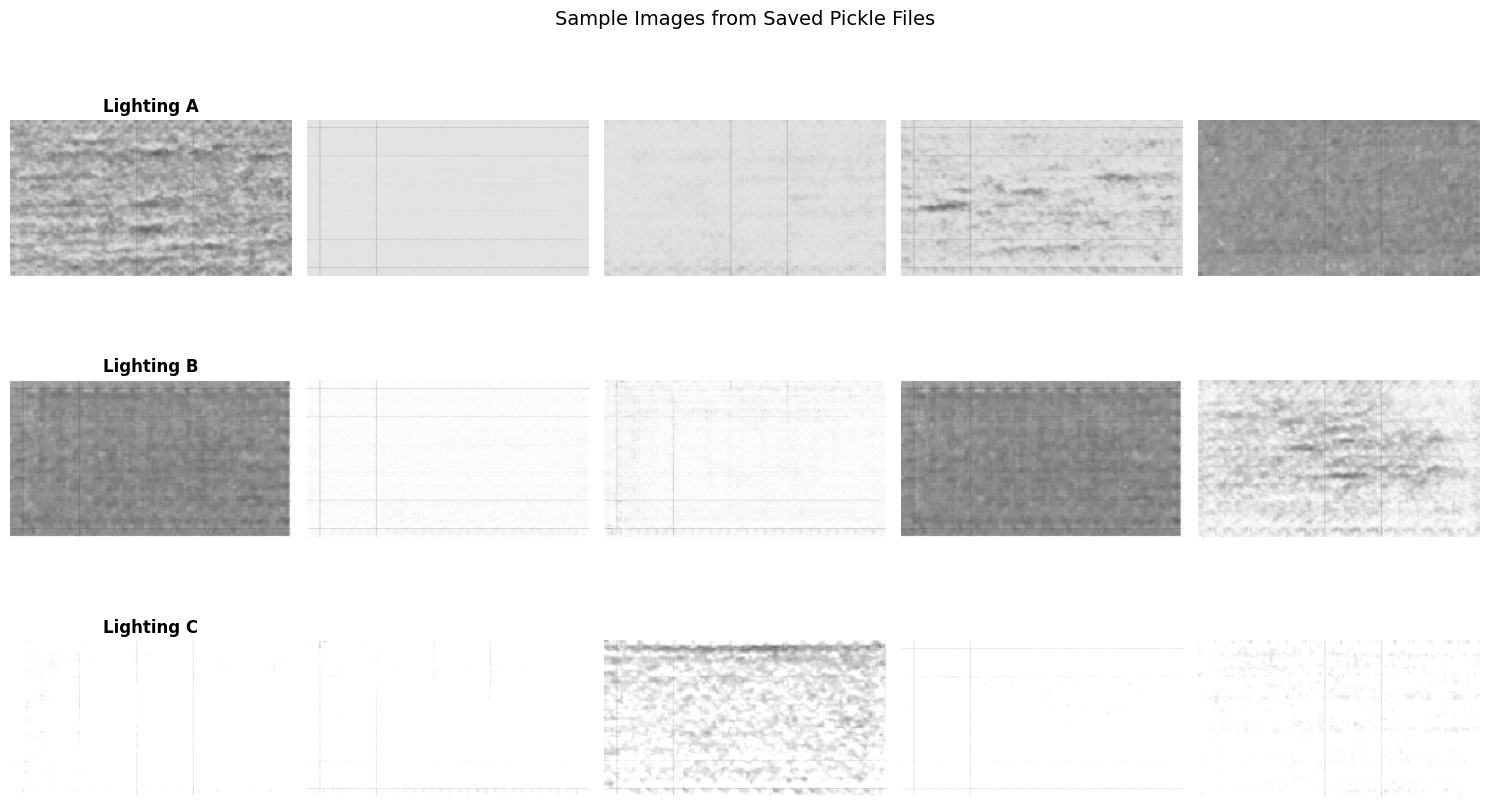

Verification complete - images successfully saved in required format!


In [2]:
# %% [markdown]
# ## Generate and Save as Pickle Files for NIST Task 2 Submission

# %%
print("Generating and saving images in correct pickle format for NIST Task 2...")

# Set to evaluation mode
netG.eval()

# Create output directory
output_dir = '/content/drive/MyDrive/Hackathon_Challenge2/'
os.makedirs(output_dir, exist_ok=True)

# Dictionary to store arrays for each lighting condition
lighting_arrays = {'a': [], 'b': [], 'c': []}

# Generate 100 images for each lighting condition
for lighting in ['a', 'b', 'c']:
    print(f"\nGenerating lighting condition '{lighting}'...")

    images_list = []

    for img_idx in range(100):
        with torch.no_grad():
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake_img = netG(noise)
            # Convert back to numpy and original scale
            fake_img = fake_img.cpu().numpy()[0, 0]  # Remove batch and channel dims
            # Crop back to original size (139, 250)
            fake_img = fake_img[2:141, 3:253]  # Remove padding
            # Convert from [-1,1] to [0,255]
            fake_img = ((fake_img + 1.0) * 127.5).astype(np.uint8)

            # Apply slight brightness variation based on lighting condition
            if lighting == 'a':
                # Slightly darker for lighting 'a'
                fake_img = np.clip(fake_img * 0.9, 0, 255).astype(np.uint8)
            elif lighting == 'c':
                # Slightly brighter for lighting 'c'
                fake_img = np.clip(fake_img * 1.1, 0, 255).astype(np.uint8)
            # lighting 'b' stays as is

            # Convert to 3-channel RGB (shape: 139, 250, 3)
            img_3ch = np.stack([fake_img, fake_img, fake_img], axis=2)

            # Add to list
            images_list.append(img_3ch)

        if (img_idx + 1) % 20 == 0:
            print(f"  Generated {img_idx + 1}/100 for lighting '{lighting}'")

    # Convert list to numpy array with shape (100, 139, 250, 3)
    lighting_arrays[lighting] = np.array(images_list, dtype=np.uint8)
    print(f"  Array shape for lighting '{lighting}': {lighting_arrays[lighting].shape}")

# Save each lighting condition as a separate pickle file
for lighting in ['a', 'b', 'c']:
    filename = f'{output_dir}NIST_Task2_{lighting}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(lighting_arrays[lighting], f)
    print(f"✅ Saved {filename}")

    # Verify the saved file
    with open(filename, 'rb') as f:
        verify_array = pickle.load(f)
    print(f"   Verified shape: {verify_array.shape}, dtype: {verify_array.dtype}")

print("\n✅ Task 2 Complete!")
print("Generated and saved 3 pickle files with correct format:")
print(f"  - NIST_Task2_a.pkl: shape (100, 139, 250, 3)")
print(f"  - NIST_Task2_b.pkl: shape (100, 139, 250, 3)")
print(f"  - NIST_Task2_c.pkl: shape (100, 139, 250, 3)")

# %% [markdown]
# ## Optional: Visualize Samples from Pickle Files

# %%
# Load and visualize samples from the saved pickle files to verify
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for lighting_idx, lighting in enumerate(['a', 'b', 'c']):
    # Load the pickle file
    with open(f'{output_dir}NIST_Task2_{lighting}.pkl', 'rb') as f:
        loaded_array = pickle.load(f)

    # Display 5 random samples
    random_indices = np.random.choice(100, 5, replace=False)
    for i, idx in enumerate(random_indices):
        axes[lighting_idx, i].imshow(loaded_array[idx])
        axes[lighting_idx, i].axis('off')
        if i == 0:
            axes[lighting_idx, i].set_title(f'Lighting {lighting.upper()}', fontsize=12, fontweight='bold')

plt.suptitle('Sample Images from Saved Pickle Files', fontsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}verification_samples.png', dpi=150)
plt.show()

print("Verification complete - images successfully saved in required format!")